Problem Set 2: Text classification
==============
(_This problem set is graded out of 50 for students taking CS4650 and out of 53 for students taking CS7650. But like all problem sets, this will count towards 8% of your final grade _)

In this problem set, you will build a system for classifying book reviews on amazon as positive or negative. You will:

- Do some basic text processing, tokenizing your input and converting it into a bag-of-words representation
- Build a classifier based on sentiment word lists
- Build a machine learning classifier based on the generative model, using Naive Bayes
- Evaluate your classifiers and examine what they have learned
- Build a machine learning classifier based on the discriminative model, using Perceptron
- Build more stable discriminative classifier, using the averaged perceptron
- Build the logistic regression classifier (See instructions within the section)
- Implement techniques to improve your classifier
- Participate in a hopefully fun bakeoff competition.

**To turn in this project, please submit on T-square:**

- this notebook
- all files in the ```gtnlplib``` directory

# 0. Set up

In order to develop this assignment, you will have to install the following, if you don't have it already.

- [python 2.7](https://www.python.org/downloads/release/python-2710/) (and not Python 3, although if somebody wants to try that and tell us what goes wrong, that would be appreciated...)
- [jupyter notebook](http://jupyter.readthedocs.org/en/latest/install.html)
- [scipy](http://www.scipy.org/install.html)
- numpy (This will come if you install scipy like above, but if not install separately)
- [nltk](http://www.nltk.org/install.html) (tested on NLTK 3.0.4)
- [matplotlib](http://matplotlib.org/users/installing.html)
- [nosetests](https://nose.readthedocs.org/en/latest/)

You also need to get the data, which is available [here](https://github.com/jacobeisenstein/gt-nlp-class/releases/tag/amazon-fall-2015). Unzip this in the "data" directory of this project.


** Notes **

- The code with this assignment also contains test\*.py files. These are used by nosetests which is one of python's framework to test your code. We will use these tests to help grade; you can run them too if you want. You can learn more about how to run them [here](http://pythontesting.net/framework/nose/nose-introduction/).
- You are free to add more tests, but that is completely optional.
- Jupyter runs in a web browser. You want to be careful about the text output from your code; if you try to output a huge amount of text, the browser will require a lot of memory, and so the notebook will become very slow and hard to use.

You are also given some code to start with. As you progress, you will be writing the missing pieces in the code and/or implementing new code. All the code is in the ** gtnlplib ** directory which came as part of the assignment. 


In [1]:
import numpy as np
from collections import defaultdict
import gtnlplib.preproc
import gtnlplib.preproc_metrics

import gtnlplib.clf_base
import gtnlplib.wordlist
import gtnlplib.naivebayes
import gtnlplib.perceptron
import gtnlplib.avg_perceptron
import gtnlplib.logreg

import gtnlplib.scorer
import gtnlplib.constants
import gtnlplib.analysis

# this enables you to create inline plots in the notebook 
%pylab inline

Populating the interactive namespace from numpy and matplotlib


While developing the modules of the library, it is likely that you make mistakes. If that happens, you correct the mistake and reload whichever modules you edited, as shown below. This is part of the python development cycle. If reloading doesn't work, restart the kernel.

In [ ]:
reload(gtnlplib.preproc)

# 1. Data Processing #
(_Completing gtnlplib.preproc.docsToBOWs() - 3 pts, each question in Deliverable 1 is worth 1 pt_)

Your first step is to write code that can apply the following
preprocessing steps. You will have to run this code fairly quickly on
the test data when you receive it, so make sure it is modular and
well-written.

- You will edit ```gtnlplib.preproc.docsToBOWs``` that takes as its argument a "key" document.
  It should produce a "BOW" (bag-of-words) document.
  Each line of the key document contains a filename and a label.
  Each line of the BOW document should contain a BOW representation of the corresponding
  file in the key document. 
- A BOW representation looks like this: "word:count word:count word:count..." for every word that appears in
  the document. Do not print words that have zero count. Use space delimiters.
- Use NLTK's [tokenization package](http://nltk.org/api/nltk.tokenize.html) function 
  to divide each file into sentences, and each sentence into tokens.
- Downcase all tokens
- Only consider tokens that are completely alphabetic.

In [2]:
### TRAINKEY, DEVKEY and TESTKEY are defined in the gtnlplib.constants module

gtnlplib.preproc.docsToBOWs(gtnlplib.constants.TRAINKEY)
gtnlplib.preproc.docsToBOWs(gtnlplib.constants.DEVKEY)
## uncomment once you have the test data
#gtnlplib.preproc.docsToBOWs(gtnlplib.constants.TESTKEY)

The ```gtnlplib.preproc``` module defines a [generator function](http://wiki.python.org/moin/Generators), called "dataIterator"

- This allows you to easily iterate through the dataset defined by a given keyfile. 
- Each time you call "next" (possibly implicitly), it returns a dict containing features and counts for the next document in the sequence. 
- In this case, the features include the words, and a special "offset" feature
- This is equivalent to $\textbf{x}_i$ in the reading.
- You can see how this is used in the getAllCounts() function below, which takes a dataIterator as an argument.


Lines 7-8 of the code in the dataIterator function might look confusing if you are not a pythonista. 

- This is a [list comprehension](http://legacy.python.org/dev/peps/pep-0202/)
nested inside a [dict comprehension](http://legacy.python.org/dev/peps/pep-0274/).
- Here's an [introduction](http://carlgroner.me/Python/2011/11/09/An-Introduction-to-List-Comprehensions-in-Python.html) with more examples.

**Sanity check**: How many unique words appear in the training set? (Types, not tokens.) In order to get this one correct you should pass the test "test_number_of_tokens"  in testpreproc.py file.

In [3]:
ac_train = gtnlplib.preproc.getAllCounts(gtnlplib.preproc.dataIterator(gtnlplib.constants.TRAINKEY))
ac_dev = gtnlplib.preproc.getAllCounts(gtnlplib.preproc.dataIterator(gtnlplib.constants.DEVKEY))
print "number of word types",len(ac_train.keys())-1

number of word types 18430


The following code makes a plot, with the log-rank (from 1 to the log of the total number of words) 
on the x-axis and the log count on the y-axis.

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log


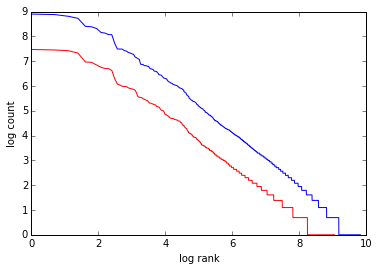

In [4]:
tr_logcounts = np.log(np.array(sorted(ac_train.values(),reverse=True)))
plt.plot(np.log(range(len(tr_logcounts))),tr_logcounts)
dv_logcounts = np.log(np.array(sorted(ac_dev.values(),reverse=True)))
plt.plot(np.log(range(len(dv_logcounts))),dv_logcounts,'r')
plt.xlabel('log rank')
plt.ylabel('log count')

**Deliverable 1**

(1 point each)

- Explain what you see in the plot.
- Print the token/type ratio for the training data.
  You will have to implement ```gtnlplib.preproc_metrics.get_token_type_ratio```

- Print the number of types which appear exactly once in the training data. These are called [hapax-legomena](https://en.wikipedia.org/wiki/Hapax_legomenon).
  You will have to implement ```gtnlplib.preproc_metrics.type_frequency```

- Print the number of types that appear in the dev data but not the training data (hint: use [sets](https://docs.python.org/2/library/sets.html) for this).
  You will have to implement ```gtnlplib.preproc_metrics.unseen_types```

(add cells with your answer)

In [5]:
# You will have to implement this function
print 'tt-train', gtnlplib.preproc_metrics.get_token_type_ratio(ac_train) 
print 'tt-dev', gtnlplib.preproc_metrics.get_token_type_ratio (ac_dev)
# tt-train 0.076057128473
# tt-dev 0.144427134487

tt-train 0.076057128473
tt-dev 0.144427134487


In [6]:
# You will have to implement this function
print 'tr-hapax-legomena',gtnlplib.preproc_metrics.type_frequency (ac_train, 1)
print 'de-hapax-legomena',gtnlplib.preproc_metrics.type_frequency (ac_dev, 1)
# tr-hapax-legomena 8758
# de-hapax-legomena 4737

tr-hapax-legomena 8758
de-hapax-legomena 4737


In [7]:
# You will have to implement this function
print 'unseen', gtnlplib.preproc_metrics.unseen_types (ac_train, ac_dev)
# unseen 12309

unseen 12309


# 2. Basic classification #
(_Completing predict() - 3 pts_)

To get started, we build a simple classifier, which labels all instances as positive. 
This is the "most common class" (MCC) baseline. 
Take a look at the implementation to see how the weights are stored and set. 

In [ ]:
weights_mcc = gtnlplib.wordlist.learnMCCWeights ()
print weights_mcc

To use these weights in a classifier, you need to complete ```gtnlplib.clf_base.predict```, which represents the inner-product computation ${\theta}' \textbf{f}(\textbf{x},y)$.
It should have the following characteristics:

- **Input 1** an instance, represented as a dict (with features as keys and counts as values) 
- **Input 2** a dictionary of weights, where keys are tuples of features and labels, and weights are the values. This corresponds to ${\theta}$ in the reading. See example below.
- **Input 3** a list of possible candidate class labels
- **Output 1** the highest-scoring label
- **Output 2** a dict with labels as keys and scores as values

Then you can call ```gtnlplib.clf_base.evalclassifier``` to compute accuracy. The relevant tests are testwlc.py.

In [ ]:
outfile = 'all_pos.txt'
mat = gtnlplib.clf_base.evalClassifier(weights_mcc,outfile, gtnlplib.constants.DEVKEY)
print gtnlplib.scorer.printScoreMessage(mat)

**Sanity check**: You should get 37.56% accuracy just by classifying everything as positive. 

- The printed output is a **confusion matrix**. 
- The rows indicate the key and the columns indicate the response. 
- In this case, the response is always "POS", so there is only one column. 
- The cell NEG/POS tells you how often an example that was labeled "NEG" in the key was labeled "POS" in the system response.

# 3. Word list classification #
(_setting weights - 2 pts, Deliverable 3 - 1 pt. Total 3 pts_)

- We will now build a sentiment analysis system based on word lists. 
- The file "data/sentiment-vocab.tff" contains a sentiment lexicon from [ Wilson et al 2005](http://people.cs.pitt.edu/~wiebe/pubs/papers/emnlp05polarity.pdf). 
- The provided function ```gtnlplib.wordlist.loadSentimentWords``` reads the lexicon into memory, building sets of positive and negative words.

In [ ]:
poswords, negwords = gtnlplib.wordlist.loadSentimentWords (gtnlplib.constants.SENTIMENT_FILE)

Now write a classifier that classifies each instance in a testfile. The classification rule is:

- 'POS' if the instance has more words from the positive list than the negative list
- 'NEG' if the instance has more words from the negative list than the positive list
- 'NEU' (neutral) if the instance has the same number of words from each list

**Deliverable 3**: run your classifier on dev.key, and use the following code to print the resulting confusion matrix. For this you will have to implement ```gtnlplib.wlclf.learnWLCWeights``` function based on the instructions given earlier in the section.

The confusion matrix should now have three columns, since the response should include every class at least once. The count of correct responses is found on the diagonal of the confusion matrix. What is the most frequent type of error?

In [ ]:
weights_wlc = gtnlplib.wordlist.learnWLCWeights (poswords, negwords)
outfile = 'word_list.txt'
mat = gtnlplib.clf_base.evalClassifier(weights_wlc,outfile, gtnlplib.constants.DEVKEY)
print gtnlplib.scorer.printScoreMessage(mat)

# 4. Naive Bayes #
(_Completing learnNBWeights() - 5 pts, Deliverable 4a - 1pt, 4b - 1 pt, explanation of plot output - 2pts. Total 8 points_)

Now you will implement a Naive Bayes classifier.

You already have the code for the decision function, "predict". 
So you just need to construct a set of weights that correspond to the classifier. 
These weights will contain two parameters:

- $\log \mu$ for the offset, which parametrizes the prior $\log P(y)$
- $\log \phi$ for the word counts, which parametrizes the likelihood $\log P(x | y)$

You should use maximum *a posteriori* estimation of
the parameter $\phi$,
$$\phi_{j,n} = P(w = n | y = j) = \frac{\sum_{i: y_i = j} x_{i,n} + \alpha}{\sum_{i:y_i=j} \sum_{n'} x_{i,n'} + V\alpha}$$
where 

- $y_i = j$ indicates the class label $j$ for instance $i$
- $w=n$ indicates word $n$
- $\alpha$ is the smoothing parameter
- $V$ is the total number of words

For each class, normalize by the sum of counts of words **in that class**. In other words, $\sum_n \phi_{j,n} = 1$ for all $j$. You can estimate $\log \phi$ directly if you prefer.

For the prior $\log P(y)$, you can use relative frequency estimation.

Both probabilities should be estimated from the training data only.
Please write this code yourself -- do not use other libraries, and try to do
it without looking at other code online.

First call ```gtnlplib.preproc.getCountsAndKeys```, which returns the following objects:

- word counts for every label in the training data.
- the count of instances with every label in the training data.
- a list of all word types that are observed in the training data

You want to do this once, because computing these counts is slow.

In [ ]:
counts, class_counts,allkeys = gtnlplib.preproc.getCountsAndKeys(gtnlplib.constants.TRAINKEY)

You will first have to implement ```gtnlplib.naivebayes.learnNBWeights```, and then run it to get the weights of the naive bayes classifier.

In [ ]:
weights_nb = gtnlplib.naivebayes.learnNBWeights (counts, class_counts, allkeys, alpha=0.1)

**Sanity check**: the word probabilities for each class should sum to 1, or very close:

In [ ]:
# sanity check!
sum([np.exp(weights_nb[('POS',basefeat)]) for basefeat in allkeys if basefeat != gtnlplib.constants.OFFSET])

**Deliverable 4a**
Train your classifier from the training data, and apply it to
the development data, with $\alpha = 0.1$. Report the confusion matrix and the accuracy.

In [ ]:
outfile = 'nb.txt'
mat = gtnlplib.clf_base.evalClassifier(weights_nb,outfile, gtnlplib.constants.DEVKEY)
print gtnlplib.scorer.printScoreMessage(mat)

**Deliverable 4b** Try at least seven different values of $\alpha$. Plot the accuracy on both the dev and training sets for each value, using [subplot](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.subplot) to show two plots in the same cell.The values of $\alpha$ should be chosen such that the max value is not at either endpoint.

In [ ]:
alphas = [] #your choice!

In [ ]:
weights_nb_alphas, tr_accs, dv_accs = gtnlplib.naivebayes.regularization_using_grid_search (alphas,counts, class_counts, allkeys)

In [ ]:
for i,alpha in enumerate (alphas):
    print alpha, tr_accs[i], dv_accs[i]

In [ ]:
# run this code to plot the accuracies
subplot(1,2,1)
plot(log(alphas),tr_accs,'bx-') 
ylabel('training accuracy')
subplot(1,2,2)
plot(log(alphas),dv_accs,'rx-')
ylabel('dev. accuracy')

(Use this cell to explain what you see in the plot above)

# 5. Feature Analysis #
(_Completing  getTopFeats() - 2 pts, Deliverable 5a - 1pt, 5b - 2 pts . Total 5 pts_)

**Deliverable 5a**
What are the words that are most predictive of positive versus negative text?
You can measure this by $\log \theta_{pos,n} - \log \theta_{neg,n}$ (which is similar to the [likelihood ratio test](http://en.wikipedia.org/wiki/Likelihood-ratio_test)).
Use $\alpha = 0.1$.

List the top five words and their counts for each class. Do the same for the top 5 words that predict negative versus positive.

** Note **

- You will have to implement ```gtnlplib.analysis.getTopFeats```. 
- You may need to sort dictionaries for getting the top features. Consider using [operator.itemgetter()](http://docs.python.org/2.7/library/operator.html) to easily sort dictionaries by their values.

In [ ]:
print gtnlplib.analysis.getTopFeats(weights_nb_alphas[1e-1],'POS','NEG',allkeys)
print gtnlplib.analysis.getTopFeats(weights_nb_alphas[1e-1],'NEG','POS',allkeys)

**Deliverable 5b** Now do the same thing for $\alpha = 10$. Which words look better to you? 
Which gave better accuracy? 
Explain what you think is going on.

In [ ]:
print gtnlplib.analysis.getTopFeats(weights_nb_alphas[10],'POS','NEG',allkeys)
print gtnlplib.analysis.getTopFeats(weights_nb_alphas[10],'NEG','POS',allkeys)

(your answer here)

# 6. Perceptron #
(_ 6 points total _)

Implement a perceptron classifier. Using the feature-function
representation, include features for each word-class pair, and also an
** offset ** feature for each class. Given a set of word counts $\vec{x}_i$,
a true label $y_i$, and a guessed label $\hat{y}$, your update will be
\begin{align*}
\hat{y} & \leftarrow \text{argmax}_y \vec{\theta}' f(\vec{x}_i,y)\\
\vec{\theta} & \leftarrow \vec{\theta} + f(\vec{x}_i, y_i) - f(\vec{x}_i, \hat{y}).
\end{align*}

Please write this yourself -- do not use any libraries, and try not to look
at other code online.

**Sanity check** If you are not careful, learning can be slow. 
You may need to think a little about how to do this update efficiently. 

- On my laptop, I can make 10 passes on the training data in roughly 30 seconds, including evaluating the accuracy on the dev and training sets. 
- You can use the ```%%timeit``` cell magic to compute statistics like this.
- Your code doesn't have to be as fast as mine, but it needs to be written intelligently, and it needs to be fast enough for you to debug it properly.
- The ```%%prun``` cell magic is also useful for diagnosing speed

To begin with we will load all the training data: the training set and the development. This will increase the speed. ```gtnlplib.preproc.loadInstances``` implementation is provided.

In [ ]:
all_tr_insts,all_dev_insts= gtnlplib.preproc.loadInstances(gtnlplib.constants.TRAINKEY, gtnlplib.constants.DEVKEY)

**Deliverable 6a** (5 points)

Implement the function ```gtnlplib.perceptron.oneItPerceptron``` that runs the perceptron for a single iteration (one pass through the training data). Its signature should be:

- **Input 1**: all training instances
- **Input 2**: a dictionary of weights, representing the current classifier at the time you call this function
- **Input 3**: a list of all possible labels
- **Output 1**: the weights after training
- **Output 2**: the number of training errors
- **Output 3**: the number of training instances

The second and third outputs allow you to compute the *training set accuracy*. This way, you can see whether you are overfitting or underfitting.

**Deliverable 6b** (1 point): Train your classifier on trainkey for ten iterations, and plot the output. For this you will have to implement ```gtnlplib.perceptron.trainPerceptron``` function making use of ```gtnlplib.perceptron.oneItPerceptron``` 

In [ ]:
outfile = "perc.txt"
w_perc,tr_acc_perc,dv_acc_perc = gtnlplib.perceptron.trainPerceptron(10, all_tr_insts,gtnlplib.constants.ALL_LABELS, outfile, gtnlplib.constants.DEVKEY)

In [ ]:
# this code makes plots of the training and development set accuracy
def makePlots(tr_acc,dv_acc):
    ax1 = plt.subplot(1,2,1,xlabel='iteration',ylabel='accuracy')
    plt.plot(tr_acc,'rx-')
    plt.title('training')
    plt.subplot(1,2,2,xlabel='iterator',sharey=ax1)
    plt.plot(dv_acc,'bx-')
    plt.title('development')

In [ ]:
makePlots(tr_acc_perc,dv_acc_perc)

**Sanity check** Your training set accuracy should increase quickly, but your dev set accuracy might be disappointing.

# 7. Averaged Perceptron #

Notice how the dev set performance of the perceptron was very unstable. Now you will try to improve it using averaging.

Conceptually, the idea is to keep a running total of the weights, and then divide at the end, after $T$ updates:

\begin{align*}
\hat{y} & \leftarrow \text{argmax}_y \theta' f(\vec{x}_i,y)\\
\theta^t & \leftarrow \theta^{t-1} + f(\vec{x}_i, y_i) - f(\vec{x}_i, \hat{y})\\
\overline{\theta} & = \frac{1}{T} \theta^T
\end{align*}

Then you can use $\overline{\theta}$ to make predictions.

But in practice, this is very inefficient. You can't store the weights after every update -- it's much too big. But you don't want to compute a running sum either. The reason is that the weight vector will quickly become dense, and this would require $O(\#F)$ operations at every update, where $\#F$ is the number of features. This is much more work than the standard perceptron update, which only involves the features that are active in the current instance. In a bag-of-words model, each document will typically have only a small fraction of the total vocabulary, and we would like each update to be linear in the number of features active in the document, not the total number of features.

An efficient solution was pointed out by [Daume 2006](http://hal3.name/docs/daume06thesis.pdf). 
Let $\delta_t$ indicate the update at time $t$.
Then, assuming $\theta^0 = 0$, we have:

\begin{align*}
\theta^t = & \theta^{t-1} + \delta_t \\
= & \sum_{t' < t} \delta_{t'}
\end{align*}

We would like to compute the sum of the weight vectors,
\begin{align*}
\sum_t^T \theta_t = & \sum_t^T \sum_{t' \leq t} \delta_{t'} = T \delta_0 + (T-1) \delta_1 + (T - 2) \delta_2 + \ldots + \delta_T \\ 
= & \sum_t^T (T - t) \delta_t\\
= & T \sum_t^T \delta_t - \sum_t^T t \delta_t \\
= & T \theta_t - \sum_t^T t \delta_t \\
\frac{1}{T} \sum_t^T \theta_t = & \theta_T - \frac{1}{T} \sum_t^T t \delta_t
\end{align*}

This means we need to keep another running sum, $\sum_t^T t \delta_t$, the sum of scaled updates. 
To compute the average, we divide by the number of updates $T$ and subtract it from the current weight vector.

**Deliverable 7a** (5 points) Implement averaged perceptron, using two functions

- an outer loop, ```gtnlplib.avg_perceptron.trainAvgPerceptron```, which should have the same inputs and outputs as  ```gtnlplib.perceptron.trainPerceptron```.
- an inner loop, ```gtnlplib.avg_perceptron.oneItAvgPerceptron```, which makes a single pass through the training data. To do weight averaging, this function may have to take some additional arguments and offer some additional outputs.

In terms of implementation, your function ```gtnlplib.avg_perceptron.oneItAvgPerceptron``` should be similar to ```gtnlplib.perceptron.oneItPerceptron```, but it needs to take additional arguments to keep track of the running sum of weights, and the total number if instances seen.  It also needs to output this information.

**Deliverable 7b** (1 point): Train your classifier on trainkey for ten iterations, and plot the output, using the code in the cells below. 

In [ ]:
reload(gtnlplib.avg_perceptron)

In [ ]:
# again, this takes roughly 30 seconds for me
outfile = "ap.txt"
w_ap,tr_acc_ap,dv_acc_ap = gtnlplib.avg_perceptron.trainAvgPerceptron(10,all_tr_insts,gtnlplib.constants.ALL_LABELS, outfile,gtnlplib.constants.DEVKEY)

In [ ]:
makePlots(tr_acc_ap,dv_acc_ap)

**Sanity check** the dev set performance should be much better than the non-averaged perceptron

**Deliverable 7c** (1 point) Use your getTopFeats function from pset 1a to compute the top ten features for positive and negative classes, by contrasting the weights $\theta_{pos,n} - \theta_{neg,n}$ and $\theta_{neg,n} - \theta_{pos,n}$

In [ ]:
print gtnlplib.analysis.getTopFeats(w_ap,'POS','NEG',allkeys, K=10)
print gtnlplib.analysis.getTopFeats(w_ap,'NEG','POS',allkeys, K=10)

# 8. Logistic regression #

Now you will complete an implementation of logistic regression.
We've provided a lot of scaffolding code, you just need to fill in some key parts.

**Deliverable 8a** (3 points): implement ```gtnlplib.logreg.computeLabelProbs``` to compute the normalized probability of each label.

- This function should have the same input arguments as your predict function
- It should output a dict, from labels to probabilities
- It will need to be fast. You may need to optimize this later. As always, ```%%prun``` and ```%%timeit``` are your friends.

**sanity check**: running the code below should give

- 'NEG': 0.0068674111043921151,
- 'NEU': 0.37494794181688146,
- 'POS': 0.61818464707872656

In [ ]:
weights = defaultdict(float)
weights[('NEG','bad')] = 1
weights[('NEG','best')] = -1
weights[('POS','bad')] = -0.5
weights[('POS','best')] = 2
weights[('NEU',gtnlplib.constants.OFFSET)] = 3
gtnlplib.logreg.computeLabelProbs({'bad':1,'best':2,gtnlplib.constants.OFFSET:1},weights,gtnlplib.constants.ALL_LABELS)

**Deliverable 8b** (3 points) Now complete the implementation of logistic regression, training by stochastic gradient descent.

- An outline of the code is provided in ```gtnlplib.logreg.trainLRbySGD```, including the regularization
- You need to provide the code that computes the update for each instance
- My implementation takes around 3 seconds per iteration over the training set
- Unlike the perceptron code, you can do everything within the single function ```gtnlplib.logreg.trainLRbySGD```
- For a reminder about how SGD works, see my notes

In [ ]:
outfile = "sgd.txt"
w_sgd,tr_acc_sgd,dv_acc_sgd = gtnlplib.logreg.trainLRbySGD(50,all_tr_insts, outfile, gtnlplib.constants.DEVKEY, regularizer=1e-1)

In [ ]:
makePlots(tr_acc_sgd,dv_acc_sgd)

# 9. Making it better #

There are two general paths for improving these classifiers: data and algorithms.

- Data-oriented approaches relate to the features. For example, you could try to use bigrams, remove stopwords, lemmatize (using wordnet), etc.
- Algorithm-oriented approaches relate to the learning itself. For example, you could implement Passive-Aggressive, AdaGrad (described in my notes), feature hashing (see [this paper](http://alex.smola.org/papers/2009/Weinbergeretal09.pdf)), alternative regularizers, or various improvements to naive bayes (see [this paper](http://people.csail.mit.edu/jrennie/papers/icml03-nb.pdf)). Note that not all these approaches will improve accuracy; some will improve speed.
- Students in 4650 should try one improvement of either type. Students in 7650 should try one improvement of each type, and for at least one of the improvements, they should cite a specific research paper that motivated their choice. The paper should be from ACL, NAACL, EMNLP, ICML, NIPS, AAAI, or a similar journal.

**Deliverable 9** (3 points for 4650; 6 points for 7650): Clearly explain what you did, and why you thought it would
work. Do an experiment to test whether it works. Creativity and thoughtfulness counts more than raw performance here.

# 10. Bakeoff! #

48 hours before the assignment is due, I will send you unlabeled test
data. Your job is to produce a response file, and submit it to our Kaggle
bakeoff ([link here](https://inclass.kaggle.com/c/gt-book-review-sentiment-analysis)).
The Kaggle contest compares your classifier's results on the dev data to generate a
class-visible leaderboard, and compares your classifier's results on the unlabeled
test data for the bakeoff. You can use the dev data results as a sanity
check, to make sure you submit the correct file.

I'll present the results in class and give the best scorers a chance to explain
what they did.

** Deliverable 10 ** (3 points) Run your best system from any part of the
assignment on the test data using the `generateKaggleSubmission()` function. Submit
your response file to the class [Kaggle bakeoff](https://inclass.kaggle.com/c/gt-book-review-sentiment-analysis). Also submit your Kaggle response file to T-Square as 'lastname-firstname.response'. The top
scores will be announced in class.

In [ ]:
yourBestWeights = weights_mcc # Change this to your best model
gtnlplib.clf_base.generateKaggleSubmission(yourBestWeights, 'lastname-firstname.response')